# "Common" not failing glacier volume evolution  

- creates `volume_evol_gfdl-esm2m_oversh_stab_rgi_reg_common_running_glaciers.nc`
- creates `volume_evol_gfdl-esm2m_oversh_stab_provide_reg_common_running_glaciers.nc`

- a bit similar to http://localhost:6261/lab/workspaces/auto-1/tree/www_lschuster/error_analysis/working_glacier_gdirs_comparison.ipynb

In [1]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
cfg.initialize()
import seaborn as sns
sns.set_context('talk')


2023-04-21 14:50:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-21 14:50:22: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-21 14:50:22: oggm.cfg: Multiprocessing: using all available processors (N=32)


In [2]:

scenarios = ['stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']
pd_geodetic = utils.get_geodetic_mb_dataframe()[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']

In [3]:
pal_colorblind = sns.color_palette("colorblind")
palette = sns.color_palette([pal_colorblind[0], pal_colorblind[-1], pal_colorblind[2],
                             pal_colorblind[1], pal_colorblind[6], pal_colorblind[4],pal_colorblind[3]])
palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [5]:
all_running_rgis_d = {}
for bc in ['_bc_1980_2019', '_bc_2000_2019']:
    pd_working = pd.read_csv(f'working_rgis_for_oversh_stab_scenarios{bc}.csv', index_col='rgiid')
    all_running_rgis_d[bc] = pd_working[scenarios].dropna().index.values
    print(len(all_running_rgis_d[bc]))
all_running_rgis = list(set(all_running_rgis_d['_bc_1980_2019']).intersection(all_running_rgis_d['_bc_2000_2019']))
pd_working_all = pd_working.loc[all_running_rgis][['area','all_running_rgis', 'rgi_reg']]

213062
212526


In [6]:
import json
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
for pi in np.arange(1,14,1):
    f = open('/home/www/lschuster/provide/provide_glacier_regions/rgi_ids_per_provide_region.json')
    if pi<10:
        Preg = f'P0{pi}'
    else:
        Preg = f'P{pi}'
    rgis_basin = json.load(f)[Preg]
    # remove connectivity level 2 glaciers only important for P03 (Greenland)
    rgis_basin = odf.loc[rgis_basin].loc[odf.loc[rgis_basin].Connect <2].index.values
    rgis_basin_w = list(set(rgis_basin).intersection(pd_working_all.index))
    pd_working_all.loc[rgis_basin_w,'provide_reg'] = Preg

In [6]:
_working = pd_working_all.loc[pd_working_all.provide_reg == 'P11']['all_running_rgis'].dropna().index.values

In [11]:
dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/provide_reg/w5e5_gcm_merged_from_2000_bc_2000_2019'
Preg = 'P11'
bc = '_bc_2000_2019'
ds = xr.open_dataset(f'{dpath}/{Preg}/provide_reg_{Preg}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc')
ds = ds.sel(rgi_id=_working).volume.isel(time=0)

NameError: name '_working' is not defined

In [10]:
_d = ds.sel(scenario='oversh_T25OS15').squeeze().dropna(dim='rgi_id')

In [12]:
_d2 = ds.sel(scenario='stab_T15').squeeze().dropna(dim='rgi_id')

In [ ]:
ds = xr.open_dataset(f'{dpath}/{Preg}/provide_reg_{Preg}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc')
ds_corr = ds.sel(rgi_id = _d2.rgi_id.values).sum(dim = 'rgi_id')

In [11]:
plt.plot(ds_corr)

<xarray.DataArray 'volume' (rgi_id: 15715)>
array([2.442374e+07, 2.667732e+05, 1.084062e+06, ..., 1.210989e+08,
       2.338181e+07, 2.181246e+05], dtype=float32)
Coordinates:
    time             float64 2e+03
  * rgi_id           (rgi_id) object 'RGI60-17.09525' ... 'RGI60-17.02498'
    hydro_year       int64 2000
    hydro_month      int64 10
    calendar_year    int64 2000
    calendar_month   int64 1
    gcm              <U10 'GFDL-ESM2M'
    scenario         <U14 'oversh_T25OS15'
    bias_correction  <U12 'bc_2000_2019'
    provide_region   <U3 'P11'
Attributes:
    description:  Total glacier volume
    unit:         m 3

In [ ]:
ds.to_dataframe()

In [ ]:
.dropna(dim='rgi_id')

In [9]:
load=False
if load:
    df_scenario_bc_l= []
    for bc in ['_bc_1980_2019','_bc_2000_2019']:
        pd_geodetic_running = pd_geodetic.loc[all_running_rgis]
        dfs = []
        for scenario in scenarios:
            df = []
            for rgi_reg in pd_working_all.rgi_reg.unique():
                if rgi_reg < 10:
                    rgi_reg_s = f'0{rgi_reg}'
                else:
                    rgi_reg_s = f'{rgi_reg}'
                dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/RGI{rgi_reg_s}'
                # amount of glaciers int that rgi region
                rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
                rgi_reg_glaciers_working = pd_working_all.loc[pd_working_all.rgi_reg == int(rgi_reg)]['all_running_rgis'].dropna().index.values
                with xr.open_mfdataset(f'{dpath}/run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_{scenario}_endyr_2500{bc}_rgi{rgi_reg_s}*.nc') as ds:
                    ds = ds.volume.load()
                    ds = ds.sel(rgi_id=rgi_reg_glaciers_working).sum(dim='rgi_id')
                    ds.coords['rgi_reg'] = rgi_reg_s
                    ds = ds.expand_dims('rgi_reg')
                    df.append(ds)
            df = xr.concat(df, dim='rgi_reg', fill_value=np.NaN)
            df.coords['scenario'] = scenario
            dfs.append(df)
            print(scenario)
        df_scenario_bc = xr.concat(dfs, dim='scenario', fill_value=np.NaN)
        df_scenario_bc.coords['bias_correction'] = bc[1:]
        df_scenario_bc_l.append(df_scenario_bc)
    df_scenario = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
    df_scenario.to_netcdf(f'volume_evol_gfdl-esm2m_oversh_stab_rgi_reg_common_running_glaciers.nc')
else:
    df_scenario = xr.open_dataset(f'volume_evol_gfdl-esm2m_oversh_stab_rgi_reg_common_running_glaciers.nc')

In [7]:
provide_reg_P01_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_2000_2019.nc

NameError: name 'provide_reg_P01_run_hydro_w5e5_gcm_merged_from_2000_endyr2500_bc_2000_2019' is not defined

In [ ]:
len(rgi_reg_glaciers_working)

In [ ]:
len(work_rgis)# == len(rgi_reg_glaciers_working)

In [ ]:
#len(work_rgis) 
#== 
len(rgi_reg_glaciers_working)

In [9]:
load=False
# do the same for the provide basins with runoff 
if load:
    df_scenario_bc_l= []
    for bc in ['_bc_2000_2019']: #'_bc_1980_2019',
        pd_geodetic_running = pd_geodetic.loc[all_running_rgis]
        df = []
        for preg in np.arange(1,14,1):
            if preg < 10:
                Preg = f'P0{preg}'
            else:
                Preg = f'P{preg}'
            dpath = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/provide_reg/w5e5_gcm_merged_from_2000_bc_2000_2019'
            # amount of glaciers int that rgi region
            #rgi_reg_glaciers = pd_geodetic.loc[pd_geodetic.reg==int(rgi_reg)].index
            rgi_reg_glaciers_working = pd_working_all.loc[pd_working_all.provide_reg == Preg]['all_running_rgis'].dropna().index.values
            with xr.open_dataset(f'{dpath}/{Preg}/provide_reg_{Preg}_run_hydro_w5e5_gcm_merged_from_2000_endyr2500{bc}.nc') as ds:
                work_rgis = ds.dropna(dim='rgi_id', how='all').rgi_id.values
                print(len(work_rgis),len(rgi_reg_glaciers_working))
                ds = ds.sel(rgi_id=rgi_reg_glaciers_working).sum(dim='rgi_id')
                df.append(ds)
        df_scenario_bc= xr.concat(df, dim='provide_region', fill_value=np.NaN)
        df_scenario_bc.coords['bias_correction'] = bc[1:]
        df_scenario_bc_l.append(df_scenario_bc)
    df_scenario = xr.concat(df_scenario_bc_l, dim='bias_correction', fill_value=np.NaN)
    df_scenario.to_netcdf(f'volume_evol_gfdl-esm2m_oversh_stab_provide_reg_common_running_glaciers.nc')
else:
    df_scenario = xr.open_dataset(f'volume_evol_gfdl-esm2m_oversh_stab_provide_reg_common_running_glaciers.nc')

In [10]:
pd_vol_scenario_rel = (100*df_scenario/df_scenario.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()
df_scenario_glob = df_scenario.sum(dim='rgi_reg')
pd_vol_scenario_glob = (100*df_scenario_glob/df_scenario_glob.sel(time=2020)).volume.to_dataframe('volume_rel_2020_%').reset_index()

ValueError: Dataset does not contain the dimensions: ['rgi_reg']

In [11]:
d_reg_num_name = {}
d_reg_num_name['01'] = 'Alaska'
d_reg_num_name['02'] = 'Western Canada & USA'
d_reg_num_name['03'] = 'Arctic Canada North'
d_reg_num_name['04'] = 'Arctic Canada South'
d_reg_num_name['05'] = 'Greenland'
d_reg_num_name['06'] = 'Iceland'
d_reg_num_name['07'] = 'Svalbard and Jan Mayen'
d_reg_num_name['08'] = 'Scandinavia'
d_reg_num_name['09'] = 'Russian Arctic'
d_reg_num_name['10'] = 'North Asia'
d_reg_num_name['11'] = 'Central Europe'
d_reg_num_name['12'] = 'Caucasus and Middle East'
d_reg_num_name['13'] = 'Central Asia'
d_reg_num_name['14'] = 'South Asia West'
d_reg_num_name['15'] = 'South Asia East'
d_reg_num_name['16'] = 'Low Latitudes'
d_reg_num_name['17'] = 'Southern Andes'
d_reg_num_name['18'] = 'New Zealand'
d_reg_num_name['19'] = 'Antarctic and Subantarctic'

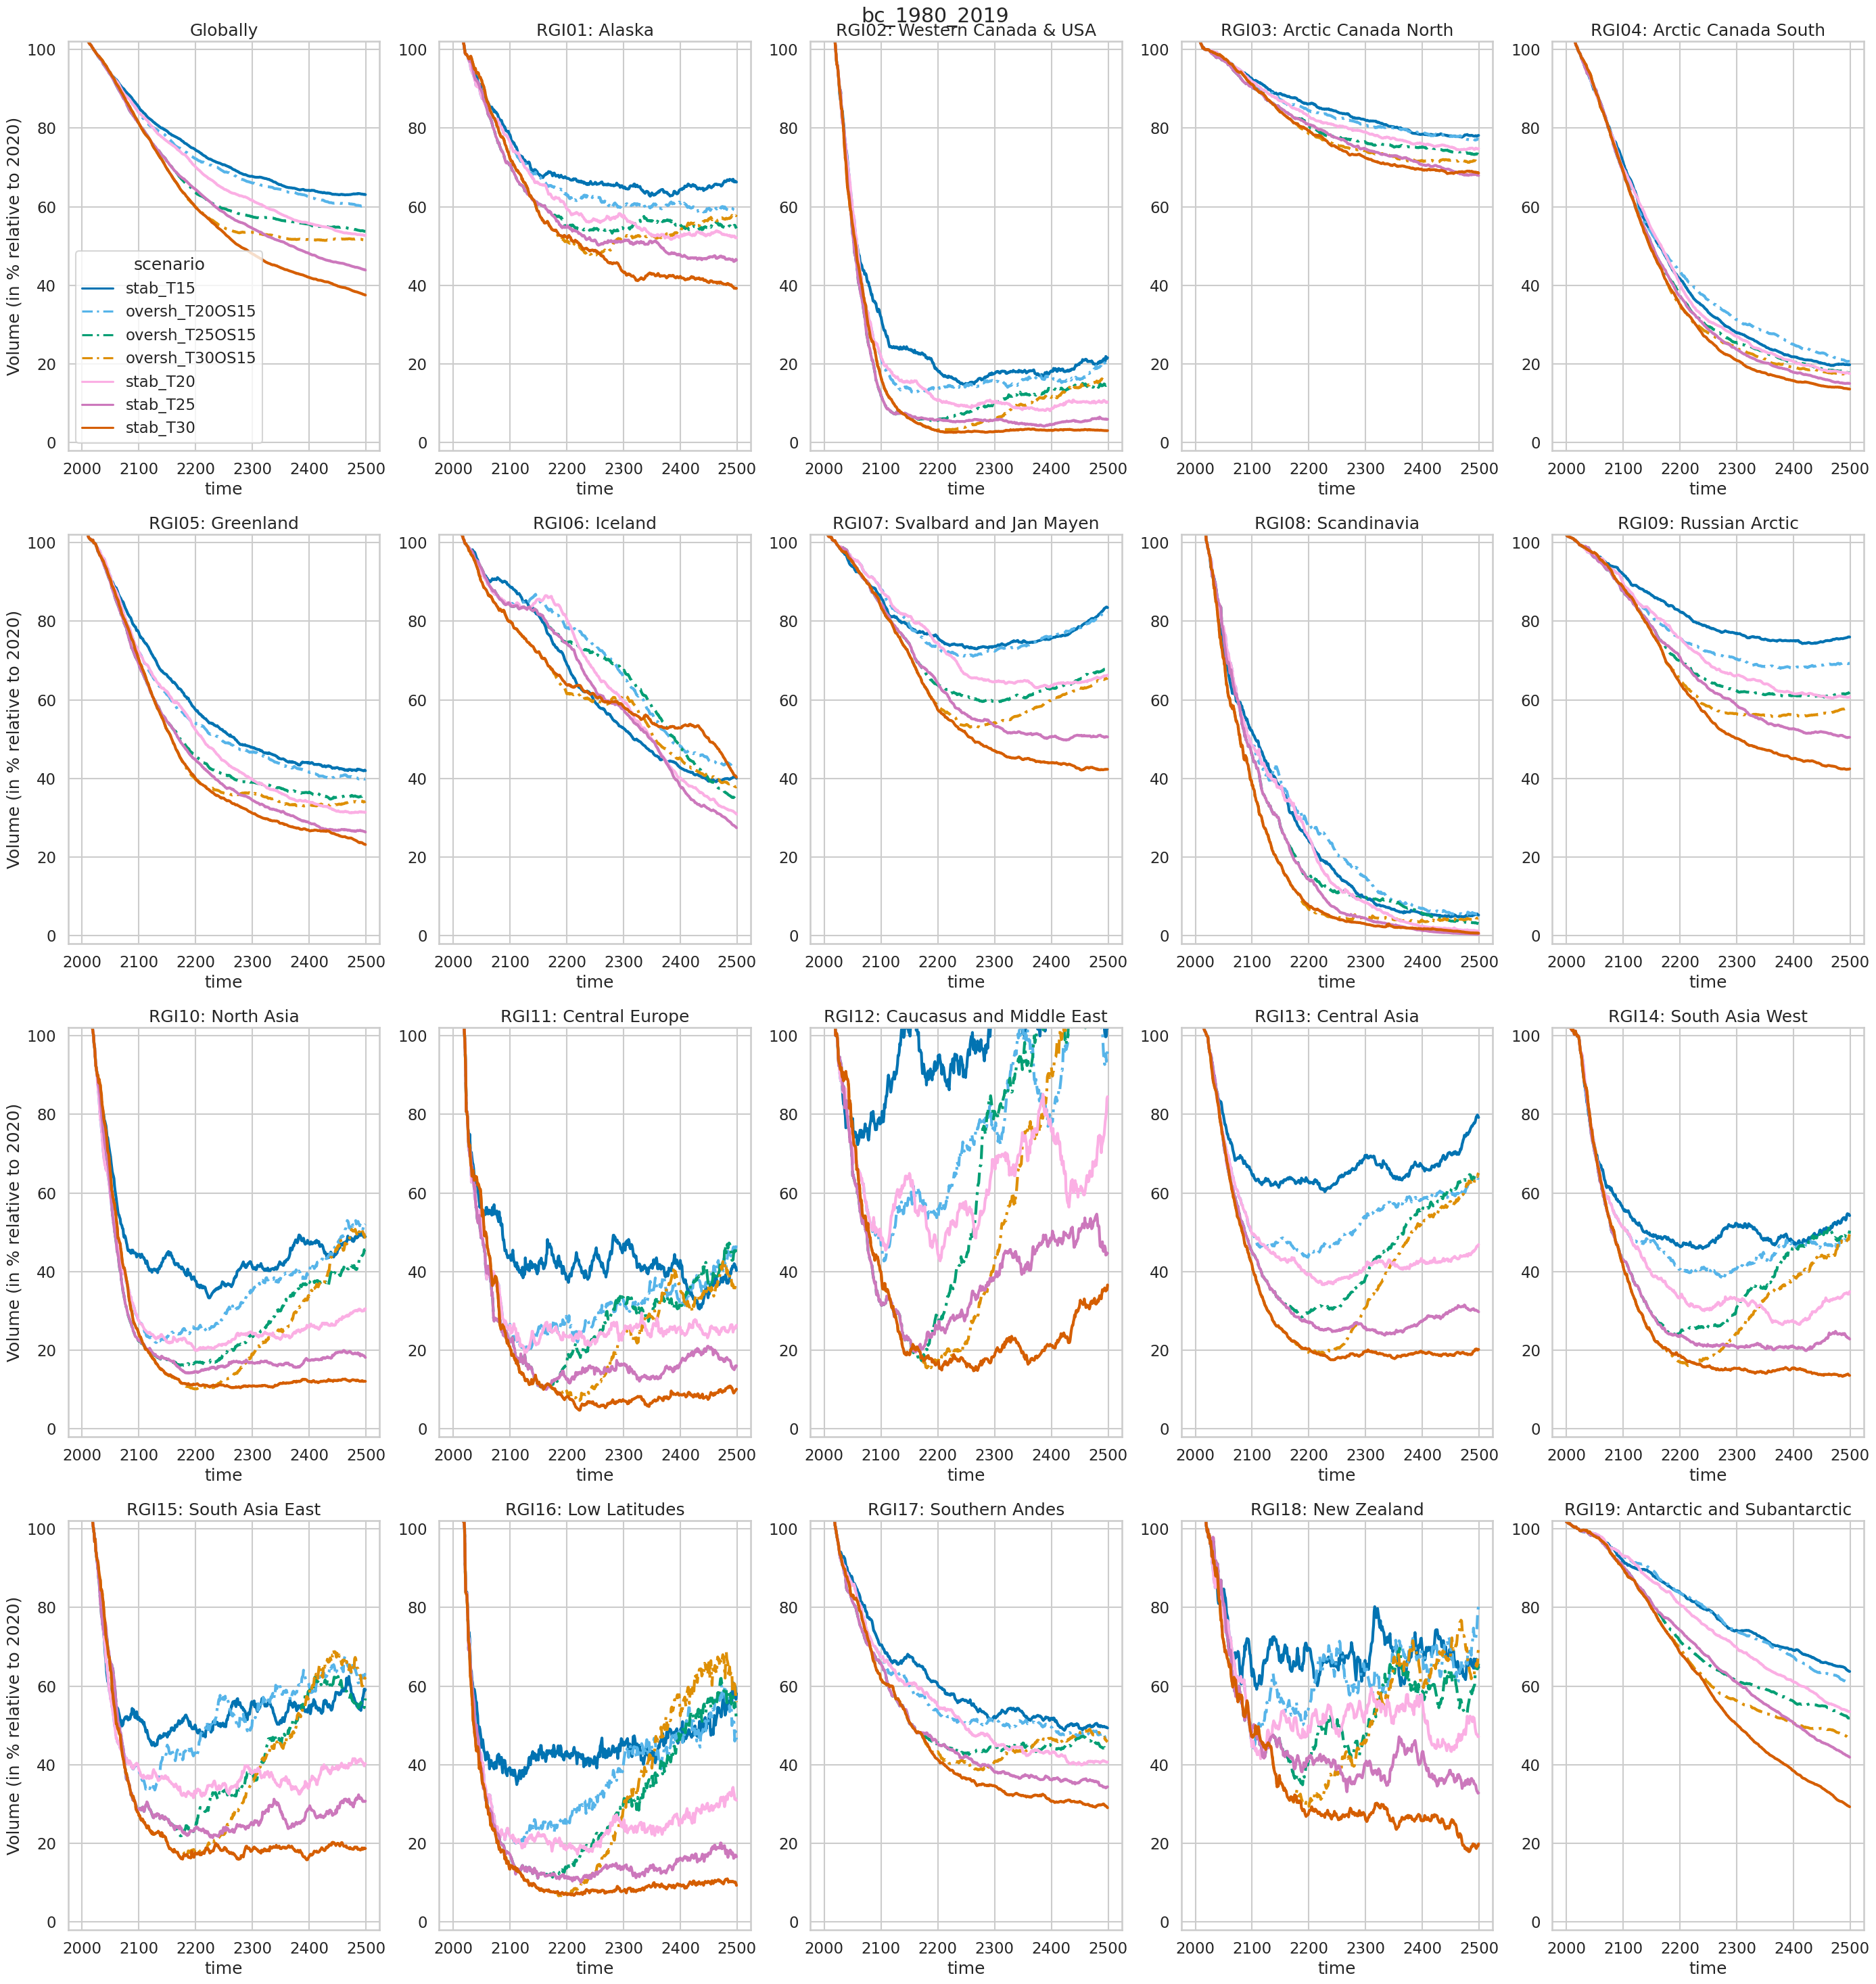

In [ ]:
plt.figure(figsize=(28,30)) #, sharey=True, sharex=True)
plt.suptitle('bc_1980_2019')
plt.subplot(4,5,1)
plt.ylabel('Volume (in % relative to 2020)')
sns.lineplot(data=pd_vol_scenario_glob.loc[pd_vol_scenario_glob.bias_correction=='bc_1980_2019'],
             hue='scenario', x='time', y= 'volume_rel_2020_%', 
             palette=palette,
             estimator='median', errorbar=('pi',100),
             style = 'scenario',
             dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
             style_order=scenarios,
             hue_order=scenarios,lw=3)
plt.title(f'Globally')
plt.ylim([-2,102]);

for j,rgi_reg in enumerate(d_reg_num_name.keys()):
    plt.subplot(4,5,j+2)
    # common glacier volume

    #if rgi_reg == '19':
    #    legend=True
    #else:
    legend=False
    pd_vol_scenario_rel_reg = pd_vol_scenario_rel.loc[pd_vol_scenario_rel.rgi_reg==rgi_reg]
    sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
                 hue='scenario', x='time', y= 'volume_rel_2020_%', 
                 estimator='median', errorbar=('pi',100),
                 palette=palette,
                 style = 'scenario',
                 dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
                 style_order=scenarios,
                 hue_order=scenarios,lw=3,legend=legend)
    
    #sns.lineplot(data=pd_vol_scenario_rel_reg.loc[pd_vol_scenario_rel_reg.bias_correction=='bc_1980_2019'],
    #             hue='scenario', x='time', y= 'volume_rel_2020_%', 
    #             estimator='median', errorbar=('pi',100),
    #             palette=palette,
    #             style = 'scenario',
    #             dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
    #             style_order=scenarios,
    #             hue_order=scenarios,lw=3,legend=False, alpha =0.3)
    
    plt.title(f'RGI{rgi_reg}: {d_reg_num_name[rgi_reg]}')
    plt.ylim([-2,102]);
    if j in [-1,4,9,14]:
        plt.ylabel(f'Volume (in % relative to 2020)')
    else:
        plt.ylabel('')
plt.tight_layout()
#if rgi_reg == '19':
#    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.03,0.9))

### Influence of bias correction

<AxesSubplot:xlabel='time', ylabel='global volume ratio\n(bc_1980_2019/bc_2000_2019)'>

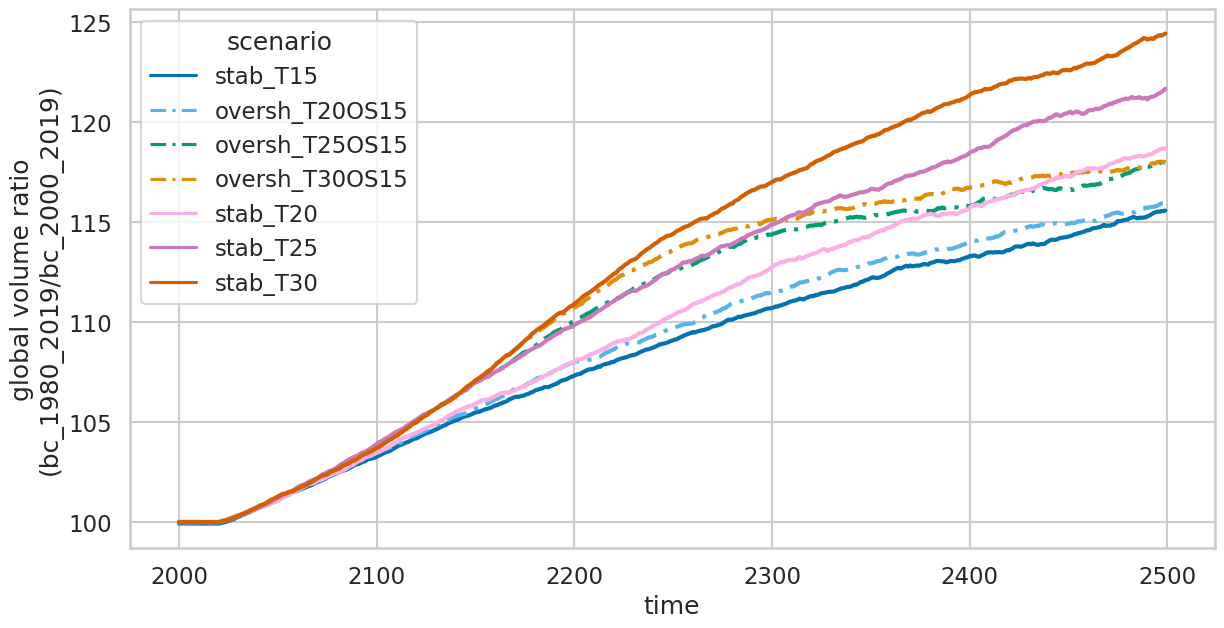

In [23]:
df_scenario_glob = df_scenario.sum(dim='rgi_reg')
pd_vol_scenario_bc_ratio = (100*df_scenario_glob.sel(bias_correction='bc_1980_2019')/df_scenario_glob.sel(bias_correction='bc_2000_2019')).volume.to_dataframe('volume_ratio_bc').reset_index()

plt.figure(figsize=(14,7))
plt.ylabel('global volume ratio\n(bc_1980_2019/bc_2000_2019)')
sns.lineplot(data=pd_vol_scenario_bc_ratio,
             hue='scenario', x='time', y= 'volume_ratio_bc', 
             estimator='median', errorbar=('pi',100),
             palette=palette,
             style = 'scenario',
             dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
             style_order=scenarios,
             hue_order=scenarios,lw=3)


In [24]:
pd_vol_scenario_reg_bc_ratio = (100*df_scenario.sel(bias_correction='bc_1980_2019')/df_scenario.sel(bias_correction='bc_2000_2019')).volume.to_dataframe('volume_ratio_bc').reset_index()

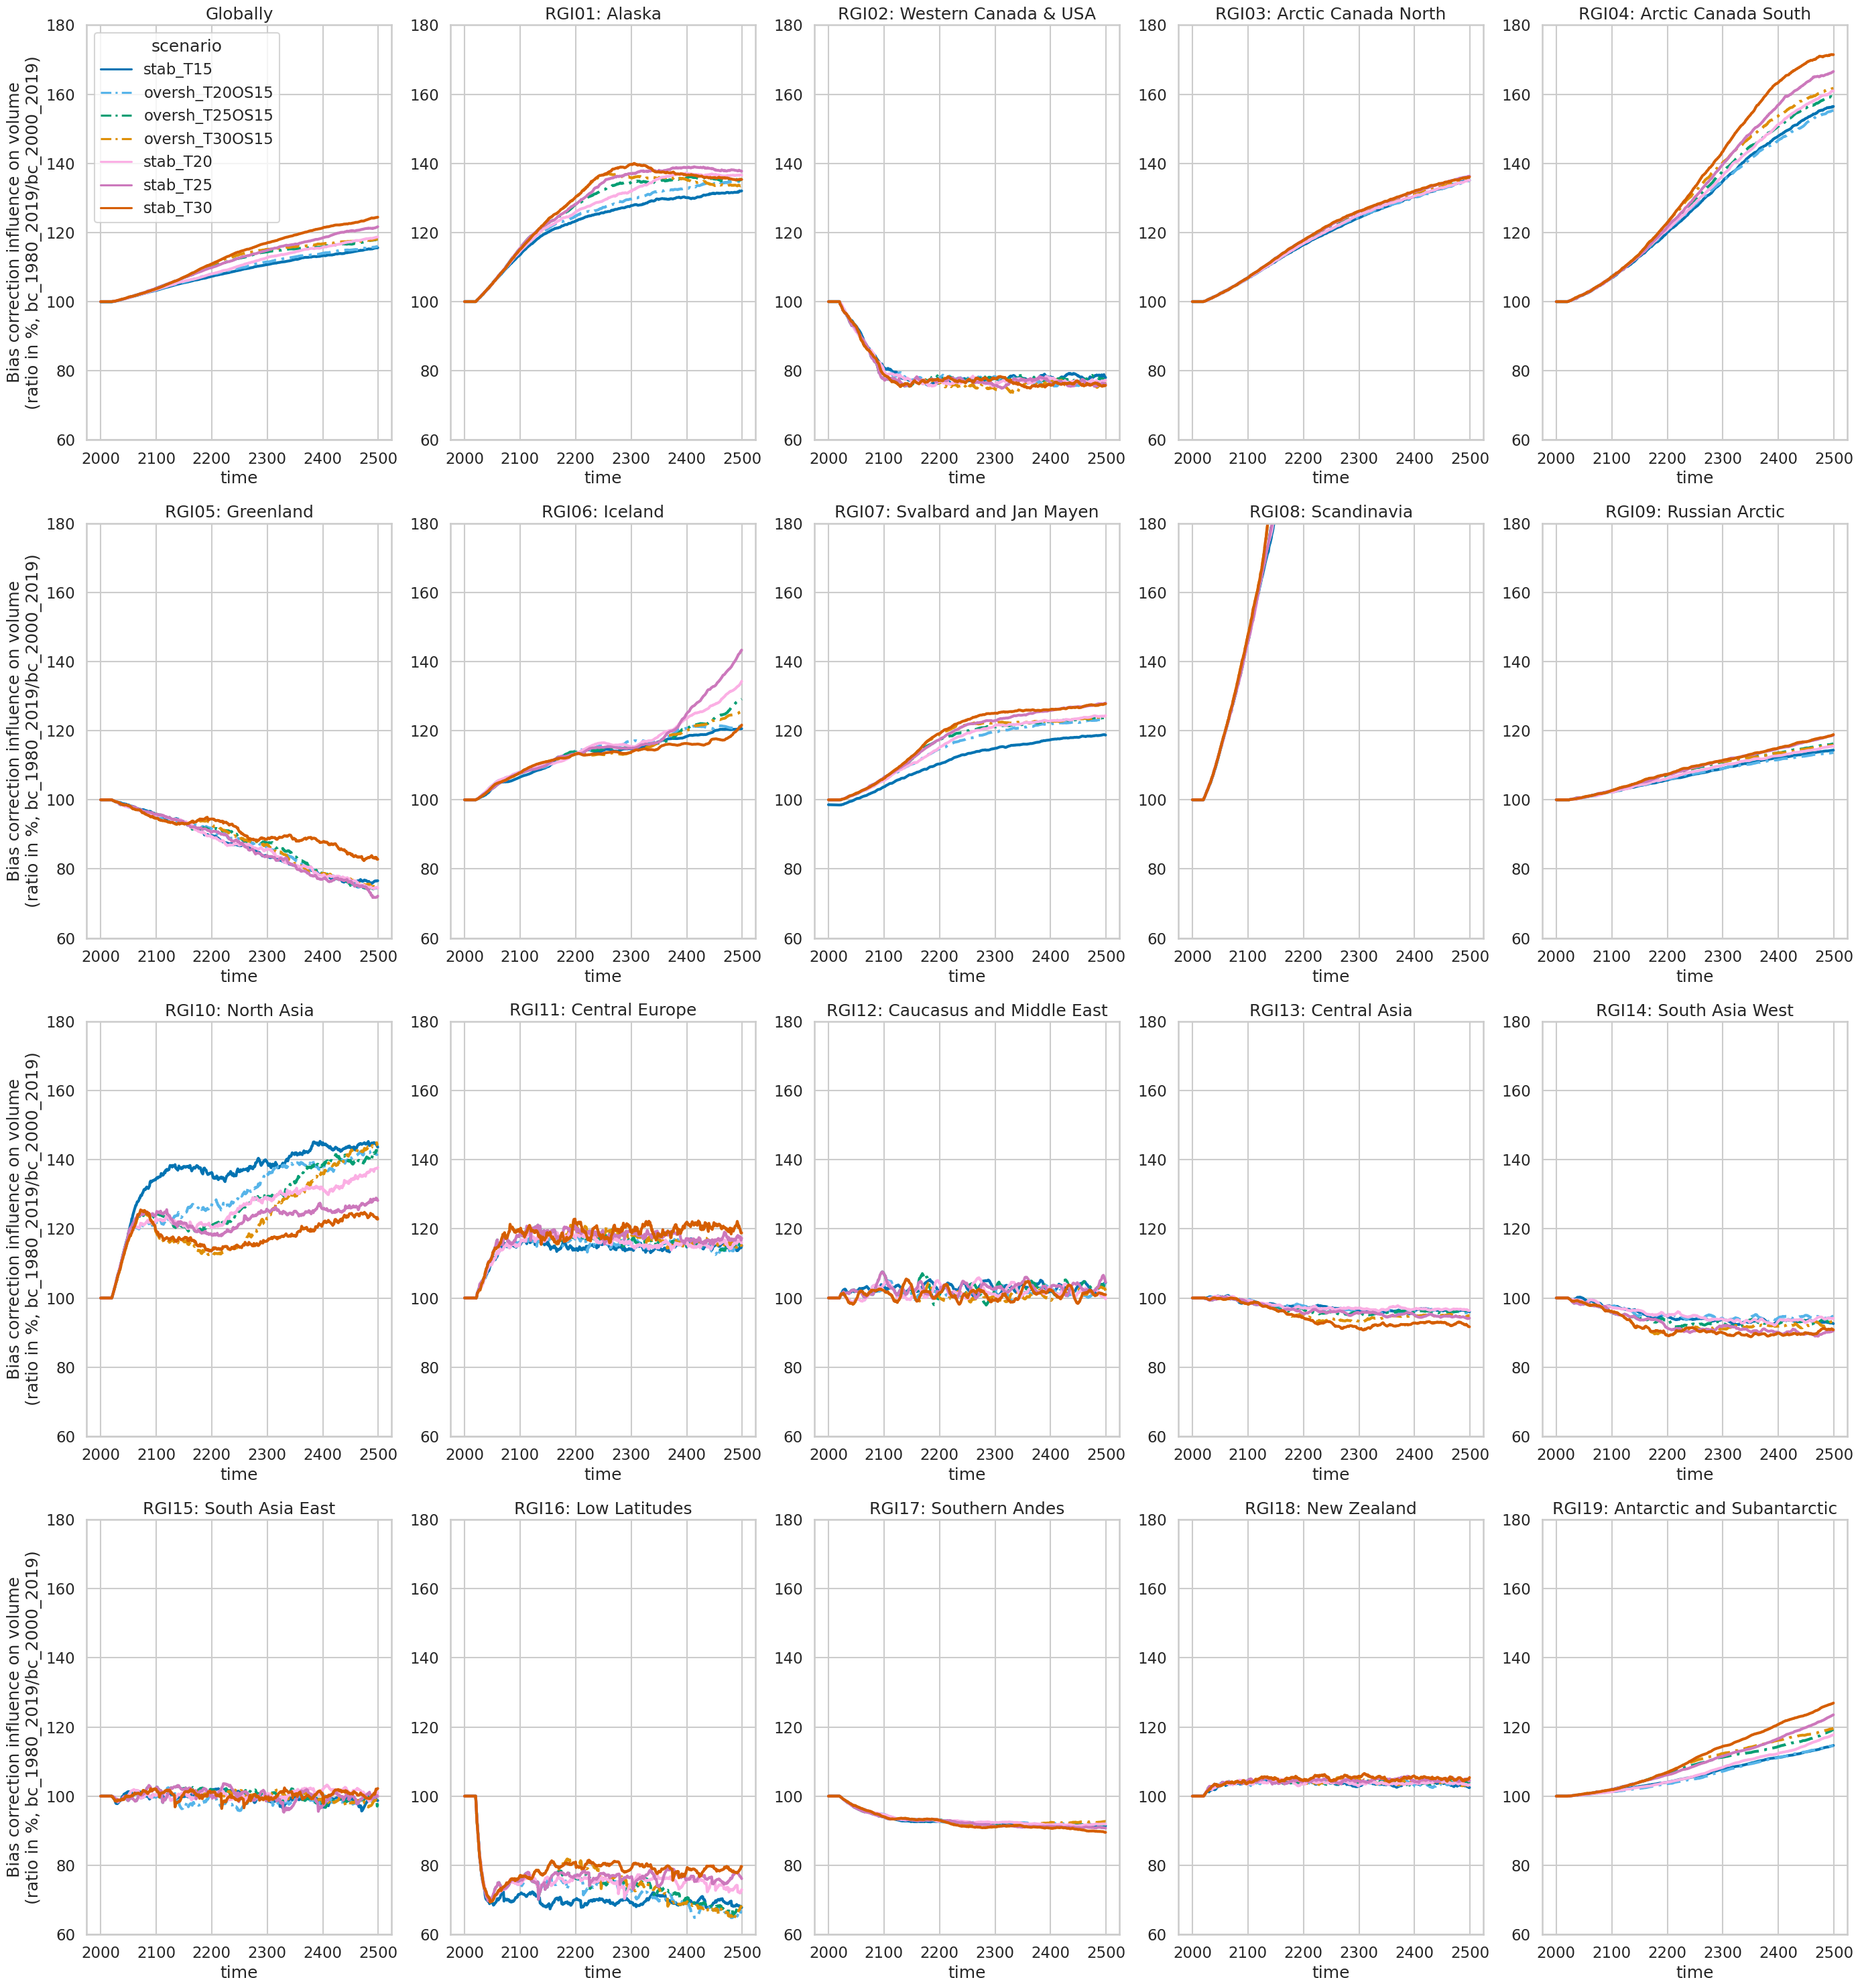

In [25]:
plt.figure(figsize=(28,30)) #, sharey=True, sharex=True)
plt.subplot(4,5,1)
plt.ylabel('Bias correction influence on volume\n(ratio in %, bc_1980_2019/bc_2000_2019)')
sns.lineplot(data=pd_vol_scenario_bc_ratio,
             hue='scenario', x='time', y= 'volume_ratio_bc', 
             estimator='median', errorbar=('pi',100),
             palette=palette,
             style = 'scenario',
             dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
             style_order=scenarios,
             hue_order=scenarios,lw=3)


plt.title(f'Globally')
plt.ylim([60,180]);
for j,rgi_reg in enumerate(d_reg_num_name.keys()):
    plt.subplot(4,5,j+2)
    # common glacier volume

    #if rgi_reg == '19':
    #    legend=True
    #else:
    legend=False
    pd_vol_scenario_reg_bc_ratio_sel = pd_vol_scenario_reg_bc_ratio.loc[pd_vol_scenario_reg_bc_ratio.rgi_reg==rgi_reg]
    sns.lineplot(data=pd_vol_scenario_reg_bc_ratio_sel,
                 hue='scenario', x='time', y= 'volume_ratio_bc', 
                 estimator='median', errorbar=('pi',100),
                 palette=palette,
                 style = 'scenario',
                 dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''],
                 style_order=scenarios,
                 hue_order=scenarios,lw=3,legend=legend)
    
    
    plt.title(f'RGI{rgi_reg}: {d_reg_num_name[rgi_reg]}')
    plt.ylim([60,180]);
    if j in [-1,4,9,14]:
        #plt.ylabel(f'Volume (in % relative to 2000)')
        plt.ylabel('Bias correction influence on volume\n(ratio in %, bc_1980_2019/bc_2000_2019)')

    else:
        plt.ylabel('')
plt.tight_layout()
#if rgi_reg == '19':
#    plt.gca().legend(loc='upper left', bbox_to_anchor=(1.03,0.9))

### Scientific question : How much more glacier melt due to overshoot compared to stabilisation in yr 2500?
- basically doing overshoot/stabilisation timeseries

In [26]:
df_scenario_bc = df_scenario.sel(bias_correction='bc_1980_2019')

In [30]:
pd_vol_scenario_reg_oversh_stab_ratio = (100*df_scenario_bc/df_scenario_bc.sel(scenario='stab_T15')).volume.to_dataframe('volume_ratio_oversh_stab').reset_index()

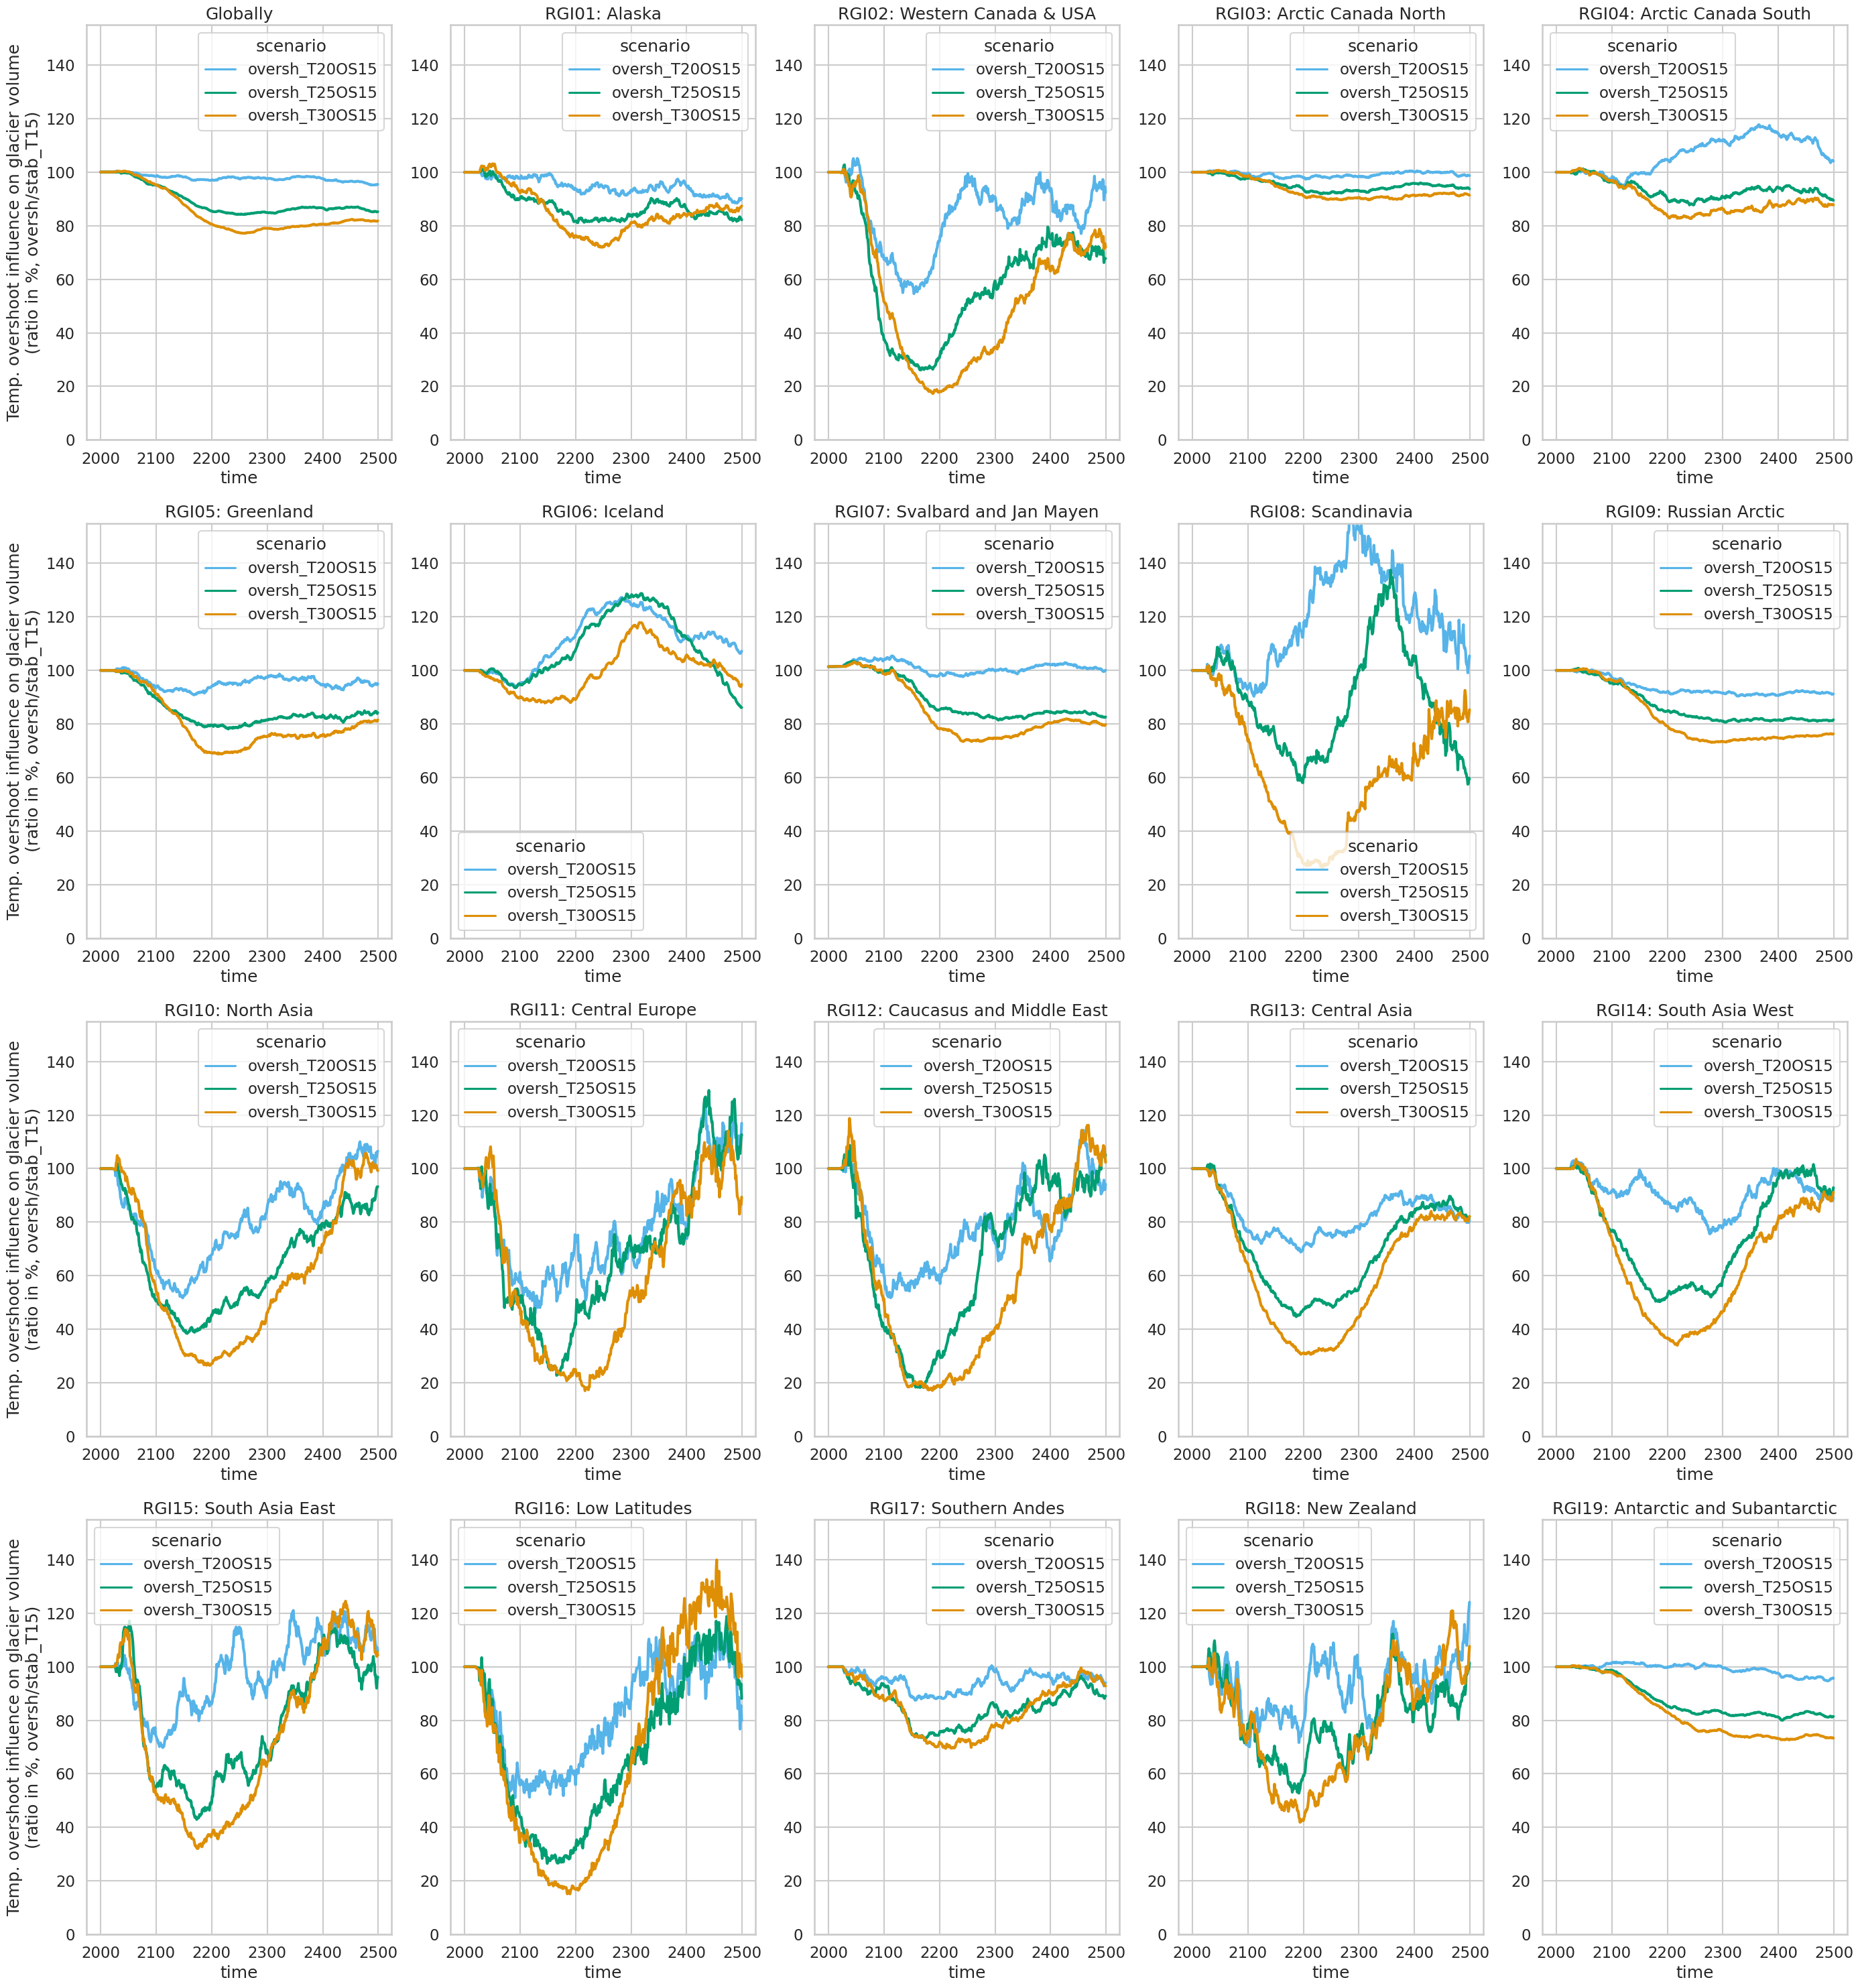

In [39]:
pd_vol_scenario_reg_oversh_stab_ratio_glob = (100*df_scenario_bc.sum(dim='rgi_reg')/df_scenario_bc.sel(scenario='stab_T15').sum(dim='rgi_reg')).volume.to_dataframe('volume_ratio_oversh_stab').reset_index()

plt.figure(figsize=(28,30)) #, sharey=True, sharex=True)
plt.subplot(4,5,1)
plt.ylabel('Temp. overshoot influence on glacier volume\n(ratio in %, oversh/stab_T15)')
sns.lineplot(data=pd_vol_scenario_reg_oversh_stab_ratio_glob,
             hue='scenario', x='time', y= 'volume_ratio_oversh_stab', 
             estimator='median', errorbar=('pi',100),
             palette=palette[1:4],
             #style = 'scenario',
             #dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''][1:4],
             #style_order=['oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15'],
             hue_order=scenarios[1:4],lw=3)

plt.title(f'Globally')
plt.ylim([0,155]);
for j,rgi_reg in enumerate(d_reg_num_name.keys()):
    plt.subplot(4,5,j+2)
    # common glacier volume

    #if rgi_reg == '19':
    #    legend=True
    #else:
    legend=False
    pd_vol_scenario_reg_oversh_stab_ratio_reg_sel = pd_vol_scenario_reg_oversh_stab_ratio.loc[pd_vol_scenario_reg_oversh_stab_ratio.rgi_reg==rgi_reg]
    sns.lineplot(data=pd_vol_scenario_reg_oversh_stab_ratio_reg_sel,
             hue='scenario', x='time', y= 'volume_ratio_oversh_stab', 
             estimator='median', errorbar=('pi',100),
             palette=palette[1:4],
             #style = 'scenario',
             #dashes=['', (5, 2, 1, 2), (5, 2, 1, 2), (5, 2, 1, 2),'','',''][1:4],
             #style_order=['oversh_T20OS15', 'oversh_T25OS15', 'oversh_T30OS15'],
             hue_order=scenarios[1:4],lw=3)
    
    
    plt.title(f'RGI{rgi_reg}: {d_reg_num_name[rgi_reg]}')
    plt.ylim([0,155]);
    if j in [-1,4,9,14]:
        #plt.ylabel(f'Volume (in % relative to 2000)')
        plt.ylabel('Temp. overshoot influence on glacier volume\n(ratio in %, oversh/stab_T15)')

    else:
        plt.ylabel('')
plt.tight_layout()

### Add global temperature

In [21]:
pd_vol_scenario_glob.time = pd_vol_scenario_glob.time.astype(int)
pd_vol_scenario_glob.index = pd_vol_scenario_glob.scenario.values + '_' + pd_vol_scenario_glob.time.astype(str).values

pd_clim_all = pd.read_csv('../annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv',index_col='Unnamed: 0')
pd_clim_global = pd_clim_all.loc[(pd_clim_all.region== 'global') & (pd_clim_all.year>=2000)]
pd_clim_global.index= pd_clim_global.scenario.values + '_'+ pd_clim_global.year.values.astype(str)

In [22]:
for scenario in scenarios: 
    pd_clim_scenario = pd_clim_global.loc[pd_clim_global.scenario == scenario]
    pd_clim_scenario.index = pd_clim_scenario.year
    temp_ref_glob, precip_ref_glob = pd_clim_scenario.loc[2000:2019][['temp','precip']].mean()
    pd_clim_scenario.index= pd_clim_scenario.scenario.values + '_'+ pd_clim_scenario.year.values.astype(str)
    pd_vol_scenario_glob.loc[pd_clim_scenario.index, 'global_temp_ch_rel_2000_2020_20yr_avg'] = pd_clim_scenario['temp_20yr_avg'].values - temp_ref_glob

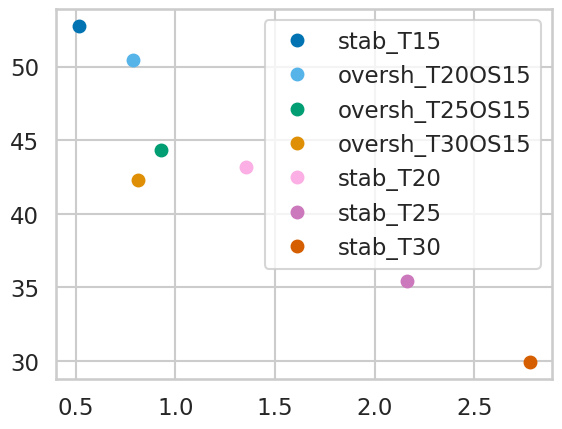

In [33]:
for j,scenario in enumerate(scenarios):
    pd_vol_scenario_glob_scenario = pd_vol_scenario_glob.loc[pd_vol_scenario_glob.scenario == scenario]
    plt.plot(pd_vol_scenario_glob_scenario.loc[pd_vol_scenario_glob_scenario.time==2479]['global_temp_ch_rel_2000_2020_20yr_avg'],
              pd_vol_scenario_glob_scenario.loc[pd_vol_scenario_glob_scenario.time==2479]['volume_rel_2000_%'],
              'o',
              color =palette[j], label=scenario)
    plt.legend()

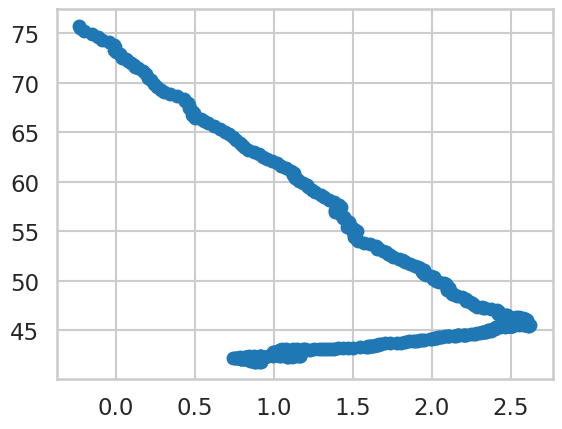

In [86]:
plt.plot(pd_vol_scenario_glob_scenario['global_temp_ch_rel_2000_2020_20yr_avg'].iloc[0:400],
         pd_vol_scenario_glob_scenario['volume_rel_2000_%'].iloc[100:500], 'o')

In [61]:
pd_clim_scenario

temp  temp_20yr_avg      precip  precip_20yr_avg  region  \
year                                                                   
2000  273.625059     273.569176  872.767294       903.399707  global   
2001  273.860453     273.571472  923.063226       904.043014  global   
2002  273.940155     273.597797  900.507135       906.128174  global   
2003  273.745386     273.653529  911.318841       908.350981  global   
2004  273.938564     273.686438  927.868499       909.484987  global   
...          ...            ...         ...              ...     ...   
2495  274.189327            NaN  943.908524              NaN  global   
2496  274.118360            NaN  941.284368              NaN  global   
2497  274.642537            NaN  957.397672              NaN  global   
2498  274.672332            NaN  928.683972              NaN  global   
2499  274.591394            NaN  908.219729              NaN  global   

      scenario  year  
year                  
2000  stab_T15  2000  
2001  stab_T15  2001  
2002  stab_T15  2002  
2003  stab_T15  2003  
2004  stab_T15  2004  
...        ...   ...  
2495  stab_T15  2495  
2496  stab_T15  2496  
2497  stab_T15  2497  
2498  stab_T15  2498  
2499  stab_T15  2499  

[500 rows x 7 columns]

In [ ]:
pd_clim_scenario_b.loc[2000:2019][['temp','precip']].mean()

In [ ]:
pd_vol_scenario_glob.loc[pd_clim_global.index,'global_temp_ch_rel_2000_2020_20yr_avg'] = pd_clim_global['temp_20yr_avg'] - 

In [56]:
pd_clim_global

temp  temp_20yr_avg      precip  precip_20yr_avg  \
stab_T15_2010        273.695574     273.800468  898.181117        912.94073   
oversh_T20OS15_2010  273.695574     273.800468  898.181117        912.94073   
oversh_T25OS15_2010  273.695574     273.800468  898.181117        912.94073   
oversh_T30OS15_2010  273.695574     273.800468  898.181117        912.94073   
stab_T20_2010        273.695574     273.800468  898.181117        912.94073   
stab_T25_2010        273.695574     273.800468  898.181117        912.94073   
stab_T30_2010        273.695574     273.800468  898.181117        912.94073   

                     region        scenario  year  
stab_T15_2010        global        stab_T15  2010  
oversh_T20OS15_2010  global  oversh_T20OS15  2010  
oversh_T25OS15_2010  global  oversh_T25OS15  2010  
oversh_T30OS15_2010  global  oversh_T30OS15  2010  
stab_T20_2010        global        stab_T20  2010  
stab_T25_2010        global        stab_T25  2010  
stab_T30_2010        global        stab_T30  2010

In [54]:
pd_clim_global['temp_20yr_avg'].loc

stab_T15_2000    273.569176
stab_T15_2001    273.571472
stab_T15_2002    273.597797
stab_T15_2003    273.653529
stab_T15_2004    273.686438
                    ...    
stab_T30_2495           NaN
stab_T30_2496           NaN
stab_T30_2497           NaN
stab_T30_2498           NaN
stab_T30_2499           NaN
Name: temp_20yr_avg, Length: 3500, dtype: float64

In [52]:
pd_clim_global

temp  temp_20yr_avg       precip  precip_20yr_avg  \
stab_T15_2000  273.625059     273.569176   872.767294       903.399707   
stab_T15_2001  273.860453     273.571472   923.063226       904.043014   
stab_T15_2002  273.940155     273.597797   900.507135       906.128174   
stab_T15_2003  273.745386     273.653529   911.318841       908.350981   
stab_T15_2004  273.938564     273.686438   927.868499       909.484987   
...                   ...            ...          ...              ...   
stab_T30_2495  276.655440            NaN  1000.557026              NaN   
stab_T30_2496  276.593450            NaN   977.280761              NaN   
stab_T30_2497  276.439443            NaN   988.368091              NaN   
stab_T30_2498  276.550307            NaN   996.359538              NaN   
stab_T30_2499  276.520417            NaN  1000.742040              NaN   

               region  scenario  year  
stab_T15_2000  global  stab_T15  2000  
stab_T15_2001  global  stab_T15  2001  
stab_T15_2002  global  stab_T15  2002  
stab_T15_2003  global  stab_T15  2003  
stab_T15_2004  global  stab_T15  2004  
...               ...       ...   ...  
stab_T30_2495  global  stab_T30  2495  
stab_T30_2496  global  stab_T30  2496  
stab_T30_2497  global  stab_T30  2497  
stab_T30_2498  global  stab_T30  2498  
stab_T30_2499  global  stab_T30  2499  

[3500 rows x 7 columns]

temp  temp_20yr_avg       precip  precip_20yr_avg  region  \
21     273.625059     273.569176   872.767294       903.399707  global   
22     273.860453     273.571472   923.063226       904.043014  global   
23     273.940155     273.597797   900.507135       906.128174  global   
24     273.745386     273.653529   911.318841       908.350981  global   
25     273.938564     273.686438   927.868499       909.484987  global   
...           ...            ...          ...              ...     ...   
66162  276.655440            NaN  1000.557026              NaN  global   
66163  276.593450            NaN   977.280761              NaN  global   
66164  276.439443            NaN   988.368091              NaN  global   
66165  276.550307            NaN   996.359538              NaN  global   
66166  276.520417            NaN  1000.742040              NaN  global   

       scenario  year  
21     stab_T15  2000  
22     stab_T15  2001  
23     stab_T15  2002  
24     stab_T15  2003  
25     stab_T15  2004  
...         ...   ...  
66162  stab_T30  2495  
66163  stab_T30  2496  
66164  stab_T30  2497  
66165  stab_T30  2498  
66166  stab_T30  2499  

[3500 rows x 7 columns]

In [28]:
pd_vol_scenario_glob

scenario    time  calendar_month  volume_rel_2000_%
0     stab_T15  2000.0               1         100.000000
1     stab_T15  2001.0               1          99.940712
2     stab_T15  2002.0               1          99.822334
3     stab_T15  2003.0               1          99.626122
4     stab_T15  2004.0               1          99.479385
...        ...     ...             ...                ...
3495  stab_T30  2495.0               1          29.438309
3496  stab_T30  2496.0               1          29.419134
3497  stab_T30  2497.0               1          29.370600
3498  stab_T30  2498.0               1          29.322786
3499  stab_T30  2499.0               1          29.267637

[3500 rows x 4 columns]